In [3]:
pip install --upgrade pillow

  Using cached pillow-10.2.0-cp39-cp39-win_amd64.whl.metadata (9.9 kB)
Using cached pillow-10.2.0-cp39-cp39-win_amd64.whl (2.6 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [2]:
pip install opencv-python easyocr

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install koreanize-matplotlib

     ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.9 MB 9.9 MB/s eta 0:00:01
     --- ------------------------------------ 0.8/7.9 MB 9.8 MB/s eta 0:00:01
     ------ --------------------------------- 1.3/7.9 MB 10.4 MB/s eta 0:00:01
     ---------- ----------------------------- 2.0/7.9 MB 11.7 MB/s eta 0:00:01
     -------------- ------------------------- 2.9/7.9 MB 13.2 MB/s eta 0:00:01
     -------------------- ------------------- 4.0/7.9 MB 15.0 MB/s eta 0:00:01
     -------------------------- ------------- 5.3/7.9 MB 17.0 MB/s eta 0:00:01
     --------------------------------- ------ 6.6/7.9 MB 18.4 MB/s eta 0:00:01
     ---------------------------------------  7.9/7.9 MB 19.5 MB/s eta 0:00:01
     ---------------------------------------- 7.9/7.9 MB 18.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


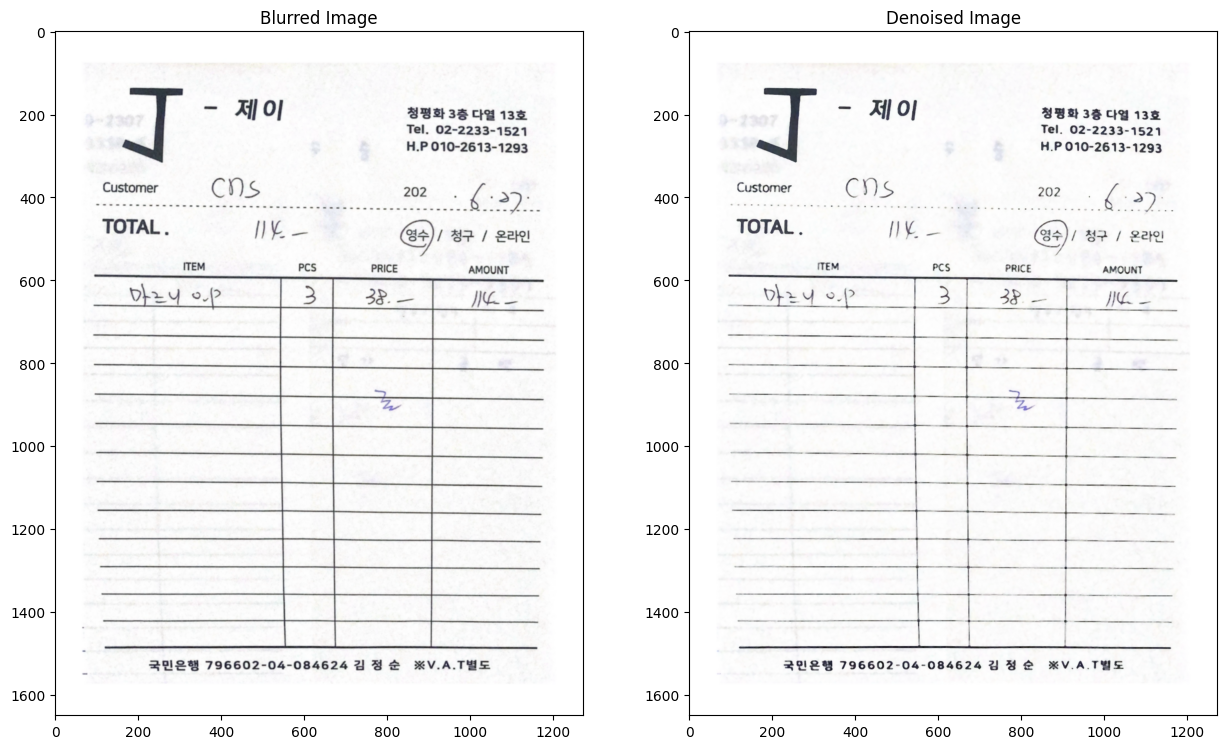

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지를 로드합니다.
image = cv2.imread('/Users/402-07/YoungMan_projectDE/receipt_list/h12.jpg')

# 가우시안 블러(Gaussian Blur)를 사용하여 노이즈를 줄입니다.
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# 중간값 필터(Median Filter)를 사용하여 소금-후추 노이즈를 제거합니다.
denoised_image = cv2.medianBlur(image, 5)

# 결과를 저장하거나 보여줍니다.
cv2.imshow('Denoised Image', denoised_image)

# 이미지를 나란히 표시하기 위한 subplot 설정
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)  # 첫 번째 subplot
plt.imshow(blurred_image)
plt.title('Blurred Image')

plt.subplot(1, 2, 2)  # 두 번째 subplot
plt.imshow(denoised_image)
plt.title('Denoised Image')

plt.show()


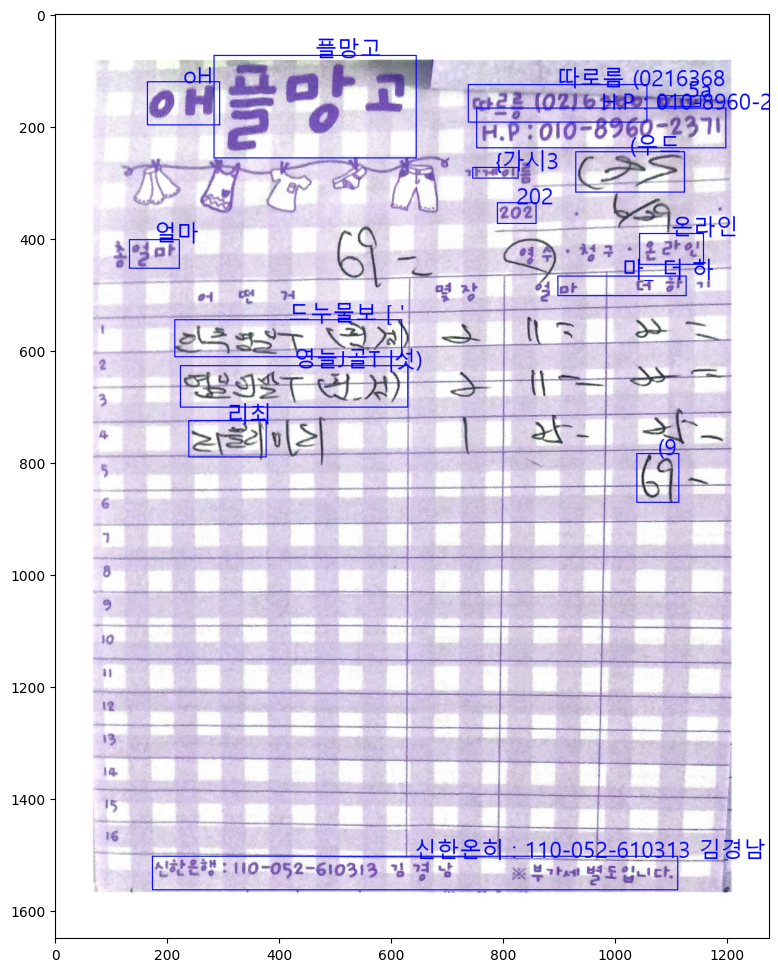

In [16]:
import cv2
import easyocr
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw, Image

num = "h02"
reader = easyocr.Reader(['ko', 'en'])
result =  reader.readtext(f'/Users/402-07/YoungMan_projectDE/receipt_list/{num}.jpg', width_ths = 15)

img = cv2.imread(f'/Users/402-07/YoungMan_projectDE/receipt_list/{num}.jpg')

img = Image.fromarray(img)
font = ImageFont.truetype("malgun.ttf", 40)
draw = ImageDraw.Draw(img)

for i in result:
  x = i[0][0][0]
  y = i[0][0][1]
  w = i[0][1][0] - i[0][0][0]
  h = i[0][2][1] - i[0][1][1]

# 나쁘지 않은 영수증 : h04, h10, h12
  draw.rectangle(((x, y), (x+w, y+h)), outline="blue", width=2)
  draw.text((int((x+x+w)/2), y-40), str(i[1]), font=font, fill="blue")

plt.figure(figsize=(15, 12))
plt.imshow(img)
plt.show()

In [10]:
import easyocr

reader = easyocr.Reader(['en', 'ko'])

results = reader.readtext('/Users/402-07/YoungMan_projectDE/receipt_list/02.jpg', width_ths = 15)

num = 0
count = 0
for (bbox, text, prob) in results:
    print(f"{text}") #// prob: {prob:.4f}")
    num += prob
    count += 1
print()
print(f"average probability : {num / count}")

영 수
등(공급받논자)
chs 귀하
00S4-재본행 _ _   2022-04-28(록} 00,339
디디
디디(DD)
청평화 지하 가 14호
전화:   HP: 010-4899-8070
010-8698-2050
Kakaostory ID: dodreami2050
KaKaoTalk ID; dodream2050
MeChat ID: dadream205o
신상마켓 ID: 디디(D8D)
22-04-28(목)    300 ,0oo   영수
품명   단가   수량     금액
비비포켓배기/베이지]|
'20,000   10   200,000
굉배기/청/S
20,000   2   40,000
굉배기/청/씨
20,000 1   20,000
굉배기/청/L
20,000   2   40,000
판매소계 --   4건   I5   300,000
코
뼈
308.808
잔
#입금처; 신한 110-484-144605 (이재혼)
#상기금액은 부가세별도 금액입니다 .
#세금계산서는 매월 5일 마갑입니다 .
(부가세 선입금) (전자)
#흰색 , 아이보리계엽 칼라교환 안돼요!
21686656813695

average probability : 0.47841329889170536


In [5]:
import easyocr


update_text = []
json_text = [] 

def extract_text_from_image(image_path, languages=['en', 'ko']):
    global update_text

    # OCR 리더 초기화
    

    blocked_characters = 'COUBJu니<{}>|]\:[_+=`!@~#$%^&*)(?;\"\''
    # 이미지 파일에서 텍스트 추출
    # 황금비율  width_ths = 15, ycenter_ths = 0.5
    try:
        text_lists = []
        reader = easyocr.Reader(languages)
        result = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5, blocklist=blocked_characters)
    
        flag = False
        list = []
    
        # 추출된 텍스트 출력
        for detection in result:
            print(detection[1])
    
        for (bbox, text, prob) in result:
                list.append(text)
        
        for text in list:
            if flag and ("판매소계" in text or "판매" in text or "판매량" in text or "만" in text or "판" in text or "민" in text or "소계" in text):
                break
            if flag:
                text_lists.append(text)
            if "금액" in text or "수량" in text or "단가" in text:
                flag = True
            
    
        # 텍스트를 추출할 때,  width_ths = 15, ycenter_ths = 0.5 의 비율로 박스를 조정하면 [품명, 단가 수량 금액] 별로 나온다.
        # 품명은 문제 없지만, 단가 수량 금액을 따로 딕셔너리로 바꾸려면 공백을 기준으로 split을 해야함.
        # 그래서 다음 코드는 짝수번째에 해당하는 배열은 그대로 두고 홀수번째에 해당하는 배열을 조정하는 것이다.
        dt = {}
        flag2 = False

    
        if("," in text_lists[0] or "." in text_lists[0]) :
            flag2 = True
    
        for i in range(0, len(text_lists)):
            if(flag2) :
                result_text = text_lists[i].split()
                if(len(result_text) == 4) :
                    dt['품목'] = result_text[0]
                    dt['단가'] = result_text[1].replace("I", "1")
                    dt['수량'] = result_text[2]
                    dt['금액'] = result_text[3] 
                    json_text.append(dt)
                    dt = {}
                else :
                    k = 0
                    n = 0
                    q = 0
                    for (j,c) in enumerate(text_lists[i]) :
                        if(c == " " and text_lists[i][j+1] == " ") :
                            dt['품목'] = text_lists[i][0:j]
                            k = j
                            break
                    text2 = text_lists[i][k+1:].strip()
                    for (m,c) in enumerate(text2) :
                         if(c == " ") :
                             dt['단가'] = text2[0:m]
                             n = m
                             break
                    text3 = text2[n+1:].strip()
                    for (z,c) in enumerate(text3) :
                        if(c == " ") :
                            dt["수량"] = text3[0:z]
                            q = z
                            break
                            
                    text4 = text3[q+1:].strip()
                    for (y,c) in enumerate(text4) :
                        if(c == " ") :
                            text4 = text4[0:y] + "." + text4[y+1:]
    
                    dt["금액"] = text4
                    
                    json_text.append(dt)
                    dt={}
            else:
                if i % 2 == 1:
                    result_text = text_lists[i].split()
                    result_text = [item for item in result_text if item]
                    update_text.append(result_text)
                    dt['단가'] = result_text[0]
                    dt['수량'] = result_text[1]
                    if len(result_text) == 3 :
                        dt['금액'] = result_text[2]
                    json_text.append(dt)
                    dt = {}
                else:
                    update_text.append(text_lists[i])
                    dt['품목'] = text_lists[i] 
    except:
        text_lists = []
        reader = easyocr.Reader(['en', 'ko'])
        # result = reader.readtext(image_path, width_ths = 15, ycenter_ths = 0.5, blocklist=blocked_characters)
        result = reader.readtext('/Users/402-07/YoungMan_projectDE/receipt_list/h12.jpg')

        flag = False
        list = []
    
        # 추출된 텍스트 출력
        for detection in result:
            print(detection[1])
    
        for (bbox, text, prob) in result:
                list.append(text)
        
        for text in list:
            if flag and ("국민은행" in text or "판매소계" in text or "판매" in text or "판매량" in text or "만" in text or "판" in text or "민" in text or "소계" in text):
                break
            if flag:
                print("########",text)
                text_lists.append(text)
            if "AMOUNT" in text or "금액" in text or "수량" in text or "단가" in text:
                flag = True
            
        print("$$$$$$$$", text_lists)
        # 텍스트를 추출할 때,  width_ths = 15, ycenter_ths = 0.5 의 비율로 박스를 조정하면 [품명, 단가 수량 금액] 별로 나온다.
        # 품명은 문제 없지만, 단가 수량 금액을 따로 딕셔너리로 바꾸려면 공백을 기준으로 split을 해야함.
        # 그래서 다음 코드는 짝수번째에 해당하는 배열은 그대로 두고 홀수번째에 해당하는 배열을 조정하는 것이다.
        dt = {}
    
        dt['품목'] = text_lists[0]
        dt['수량'] = text_lists[1].replace("I", "1")
        dt['단가'] = text_lists[2].replace("-", "000")
        dt['금액'] = text_lists[3].replace("I", "1").replace("C", "4") + "000"
        json_text.append(dt)
        dt = {}
        
       


# 아쉬운 리스트 : 05(짝수번째 배열을 통째로 인식함), 06(짝수번째 배열을 통째로 인식함), 08(짝수번째 배열을 통째로 인식함) 10(컬럼이 표시 안됨), 12(인식을 못함),
# 13(인식을 못함), 14(인식을 못함), 16(인식을 못함), 18(인식을 못함)
# 수정 성공 : 06(블록리스트를 이용하여 수정함)

# 되는거 : 01, 02, 03, 04, 05, 06, 07, 08, 09, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26
# 깔끔하진 않지만 컬럼에 들어오는거 : 06, 10, 12, 19
# 안되는거 : 
# 이미지 파일 경로 설정
image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/02.jpg'  # 본인이 사용하는 이미지 파일로 경로를 변경하세요.

# 언어 설정 및 이미지에서 텍스트 추출
extract_text_from_image(image_path, languages=['en', 'ko'])
# print(text_lists)
# print(update_text)
print(json_text)


영 수
증요공급받는자
chs 귀하
00S4-재본행       2022-04-280록변 00,339
디디
디디DD흘
청평화 지하 가 14호
전화   HPi 010-4899-8070
010-8698-2050
Kakaostory ID펼 dodreami2050
KaKaoTalk IDi dodream2050
Melhat IDA dadream205o
신상마켓 IDi 디디lD8D
22-04-281목꼭    300 ,0oo   영수
품명   단가   수량     금액
비비포켓배기/베이지-N
20,000   10   200,000
굉배기/청/S
20,000   2   40,000
굉배기/청/씨
20,000 1   20,000
굉배기/청/L
20,000   2   40,000
판매소계 --   4건   I5   300,000
코
뼈
308.808
잔
뉴입금처창 신한 110-484-144605 m이재혼
규상기금액은 부가세별도 금액입다다 .
x세금계산서는 매월 5입 마갑입다다 .
부가세 선입금초  전자흘
노흰색 , 아이보리계엽 칼라교환 안돼요
21686656813695
[{'품목': '비비포켓배기/베이지-N', '단가': '20,000', '수량': '10', '금액': '200,000'}, {'품목': '굉배기/청/S', '단가': '20,000', '수량': '2', '금액': '40,000'}, {'품목': '굉배기/청/씨', '단가': '20,000', '수량': '1', '금액': '20,000'}, {'품목': '굉배기/청/L', '단가': '20,000', '수량': '2', '금액': '40,000'}]


In [11]:
import easyocr
import re

text_list = []
def find_by_date(image_path, languages=['en', 'ko']):
    global text_list

    # OCR 리더 초기화
    reader = easyocr.Reader(languages)

    blocked_characters = ';이터,'
    
    # 이미지 파일에서 텍스트 추출
    result = reader.readtext(image_path, width_ths = 0.5, ycenter_ths = 0.5, blocklist=blocked_characters)

    # 추출된 텍스트 확인 
    # for detection in result:
    #     print(detection[1])

    for (bbox, text, prob) in result:
        text_list.append(text)

    # 정규식 패턴
    pattern = r'(\d{4}-\d{2}-\d{2})'

    for text in text_list:
        match = re.search(pattern, text)
        month_match = re.search(date_pattern, text)

        if match:
            date_part = match.group(1)  # 날짜 부분
            print(date_part)
            break
        # elif month_match:
        #     month_part = month_match.group(1)
        #     print(month_part)
        #     break

# 사용 가능 01, 02, 03, 04, 05, 07, 08, 09, 11, 15, 17

image_path = '/Users/402-07/YoungMan_projectDE/receipt_list/04.jpg'
print(text_list)
find_by_date(image_path, languages=['en', 'ko'])

[]
2022-04-25


In [11]:
import json

json_text = json.dumps(json_text, ensure_ascii=False, indent=4)


print(json_text)


[
    {
        "품목": "비비포켓배기/베이지-N",
        "단가": "20,000",
        "수량": "10",
        "금액": "200,000"
    },
    {
        "품목": "굉배기/청/S",
        "단가": "20,000",
        "수량": "2",
        "금액": "40,000"
    },
    {
        "품목": "굉배기/청/씨",
        "단가": "20,000",
        "수량": "1",
        "금액": "20,000"
    },
    {
        "품목": "굉배기/청/L",
        "단가": "20,000",
        "수량": "2",
        "금액": "40,000"
    }
]
